# LSTM using logMAR, interventions and delta_t to predict next logMAR
- Aim: baseline model before integrating OCT imaging data
- Test different LSTM models - i.e. modelling delta_t in forget/memory gate

In [1]:
%load_ext tensorboard

In [14]:
import sys
sys.path.append('../')

from estimators import Estimator, merged_config, plot_train_curve_comparison
import models
import losses
from datasets import IOVar
from sequences import load_sequences_from_pickle
import matplotlib.pyplot as plt
import logging
import os
import tensorflow as tf

logging.basicConfig(level=logging.INFO) # need one of this?
logging.getLogger().setLevel(logging.INFO) # need one of this?

In [133]:
import logging 
from enum import Enum

class IOVar(Enum):
    CUR_VA = 1
    NEXT_VA = 2
    OCT = 3
    DELTA_T = 4
    INJ_SHORT = 5
    INJ_LONG = 6
    LENS_SURGERY = 7
    
    def get_data_from_mmt(self, mmt):
        # self is the member
        cls = self.__class__
        if self == cls.CUR_VA:
            return mmt.cur_va
        elif self == cls.NEXT_VA:
            return mmt.next_va
        elif self == cls.OCT:
            return mmt.oct_path
        elif self == cls.DELTA_T:
            return mmt.delta_t
        elif self == cls.INJ_SHORT:
            return sum(mmt.injections)
        elif self == cls.INJ_LONG:
            return mmt.injections
        elif self == cls.LENS_SURGERY:
            return int(mmt.lens_surgery)
        
    def get_dtype(self, flavour='tf'):
        cls = self.__class__
        if self == cls.OCT:
            return tf.string if flavour == 'tf' else np.string
        else:
            return tf.float32 if flavour == 'tf' else np.float32

        
    def get_shape(self, num_samples=None, sequence_length=None):
        cls = self.__class__
        if self == cls.INJ_LONG:
            return (num_samples, sequence_length, 8)
        else:
            return (num_samples, sequence_length, 1)
        
        
class LongitudinalOCTDataset():
    def __init__(self, sequences, return_values=(IOVar.OCT,IOVar.NEXT_VA), norm=None, sequence_length=None, num_inputs=-1, 
                 num_parallel_calls=1):
        """
        Create tf.Dataset from sequences. The dataset will return return_values assembled from sequences with shape
        ((num_samples, sequence_length, var1_shape),...) 
        Sequence loading and splitting is done outside of this class.
        NOTE: does not support nested tuples for return_values
        Args:
            sequences: list of MeasurementSequences
            return_values: tuple, definition of variables that the dataset returns
            norm: list of tuples (mean, std). Values for normalizing each entry X of return_values X: (X-mean)/std. 
                Can be None for individual entries. Shape should fit return_values
            sequence_length: if None, take length of first sequence - 1 as sequence length for dataset.
                Pad with zeros, if sequence is shorter than sequence_length
        """
        self.log = logging.getLogger(self.__class__.__name__)
        self.sequences = sequences
        self.return_values = return_values
        if norm is None:
            norm = tuple([None for _ in return_values])
        self.norm = norm
        if sequence_length is None:
            sequence_length = len(self.sequences[0]) - 1
        self.sequence_length = sequence_length
        self.num_samples = len(self.sequences)
        self.num_parallel_calls = num_parallel_calls
        self.num_inputs = num_inputs
        
        self.dataset = self._get_dataset()
        self.dataset_for_training = self._get_dataset_for_training()
        self.dataset_for_prediction = self._get_dataset_for_prediction()
    
    def _get_dataset(self):
        data = self._prepare_data()
        def generator():
            for i in range(self.num_samples):
                yield tuple([el[i] for el in data])
               
        output_types = tuple([io_var.get_dtype('tf') for io_var in self.return_values])
        output_shapes = tuple([io_var.get_shape(sequence_length=self.sequence_length)[1:] for io_var in self.return_values])
        dataset = tf.data.Dataset.from_generator(generator=generator, 
                                                 output_types=output_types, 
                                                 output_shapes=output_shapes)
        #dataset = dataset.shuffle(self.num_samples, seed=42, reshuffle_each_iteration=False)
        
        # map octs
        if IOVar.OCT in self.return_values:
            idx = self.return_values.index(IOVar.OCT)
            def read_oct(*data):
                # read OCT
                data[idx] = 'loaded OCT' # TODO
                return data
            dataset = dataset.map(read_oct, num_parallel_calls=self.num_parallel_calls)
            
        # normalize values
        def norm(*data):
            normed_data = []
            for i in range(len(data)):
                if self.norm[i] is not None:
                    mean, std = self.norm[i]
                    normed_data.append((data[i]-mean)/std)
                else:
                    normed_data.append(data[i])
            return tuple(normed_data)
        dataset = dataset.map(norm, num_parallel_calls=self.num_parallel_calls)
        return dataset
    
    def _get_dataset_for_training(self):
        def map_fn(*data):
            return data[:self.num_inputs], data[self.num_inputs:]
        return self.dataset.map(map_fn)

    def _get_dataset_for_prediction(self):
        def map_fn(*data):
            return [data[:self.num_inputs]]
        return self.dataset.map(map_fn)
     
    def _prepare_data(self):
        """
        Read data from self.sequences according to self.return_values. 
        Replace oct image with oct_path -- this will be loaded later using the generator
        """
        data = []
        for io_var in self.return_values:
            # get number of features for each config element
            arr = np.zeros(io_var.get_shape(self.num_samples, self.sequence_length), dtype=io_var.get_dtype("np"))
            data.append(arr)
        
        for i, seq in enumerate(self.sequences):
            for j, mmt in enumerate(seq.measurements[::-1][1:]):
                # go through measurements in reverse order to ensure we get the latest ones
                k = self.sequence_length-j-1
                if k < 0:
                    break
                for l, io_var in enumerate(self.return_values):
                    data[l][i,k] = io_var.get_data_from_mmt(mmt)
        return data
                     
        
    def get_value_list(self, values=[], batch_size=512):
        idx = [self.return_values.index(io_var) for io_var in values]
        res = [np.zeros(io_var.get_shape(0, self.sequence_length)) for io_var in values]
        for X in self.dataset.batch(batch_size):
            for i in range(len(res)):
                res[i] = np.concatenate([res[i], X[idx[i]]])
        return res
    

In [160]:
class SimpleLSTMModel():
    def __init__(self, input_vars, output_vars, sequence_length):
        """
        Basic LSTM architecture which concatenates all inputs and predicts a single output
        """
        assert IOVar.OCT not in input_vars, "cannot use input OCT in SimpleLSTM"
        assert len(output_vars) == 1, "only support one output with this architecture!"
        self.input_vars = input_vars
        self.sequence_length = sequence_length
        self.log_layers = []
        
        self.inputs = [tf.tensorflow.keras.layers.Input(io_var.get_shape(sequence_length=sequence_length)[1:]) for io_var in self.input_vars]
        X = self._input_layers(self.inputs)
        X = self._embedding_layers(X)
        X = self._lstm_layers(X)
        X = self._output_layers(X)
        self.outputs = [X]
        
        self.model = tf.tensorflow.keras.Model(self.inputs, self.outputs)
        self.layers = self.model.layers
        self.summary = self.model.summary

    def _input_layers(self, X):
        # concatenate inputs, then split along sequence dimension
        if len(X) > 1:
            X = tf.tensorflow.keras.layers.concatenate(X, axis=-1)
        else:
            X = X[0]
        return X
    
    def _embedding_layers(self, X):
        X = tf.tensorflow.keras.layers.Lambda(lambda x: tf.split(x, self.sequence_length, axis=1))(X)
        dense_layer = tf.tensorflow.keras.layers.Dense(32, activation='relu')
        X = [dense_layer(x) for x in X]
        if len(X) > 1:
            X = tf.tensorflow.keras.layers.concatenate(X, axis=1)
        else:
            X = X[0]
        
        self.log_layers.append(dense_layer)
        return X
    
    def _lstm_layers(self, X):
        lstm_layer = tf.tensorflow.keras.layers.LSTM(units=64, return_sequences=True)
        X = lstm_layer(X)
        
        self.log_layers.append(lstm_layer)
        return X
    
    def _output_layers(self, X):
        # split X and calculate output for each element
        X = tf.tensorflow.keras.layers.Lambda(lambda x: tf.split(x, self.sequence_length, axis=1))(X)
        output_layer = tf.tensorflow.keras.layers.Dense(1, activation=None)
        X = [output_layer(x) for x in X]
        if len(X) > 1:
            X = tf.tensorflow.keras.layers.concatenate(X, axis=1)
        else:
            X = X[0]
        self.log_layers.append(output_layer)
        return X
    
# should go in losses
def mae_last(y_true, y_pred):
    return tf.math.abs(y_pred[:,-1] - y_true[:,-1])

def mae_last_numpy(y_true, y_pred, index=-1):
    return np.mean(np.abs(y_pred[:,index] - y_true[:,index]))

def merged_config(config1, config2):
    """update config1 with config2"""
    res_config = deepcopy(config1)
    for key, value in res_config.items():
        res_config[key].update(config2.get(key, {}))
    return res_config


DEFAULT_CONFIG = {
    'sequence_data': {
        'sequence_fname': None,
        'load_sequences': False
    },
    'sequence_split': {
        'sequence_length': 5,
        'train_frac': 0.8,
        'val_frac': 0.1,
        'diagnosis': 'AMD',
        'seed': 42
    },
    'model': {
        'model_cls': SimpleLSTMModel,
        'input_vars': [IOVar.CUR_VA,IOVar.DELTA_T,IOVar.INJ_SHORT,IOVar.LENS_SURGERY],
        'output_vars': [IOVar.NEXT_VA,],
        'norm': [None, None, None, None, None],
        'sequence_length': 1,
        'num_dataloaders': 1,
    },
    'training': {
        'loss': tf.losses.mean_absolute_error,
        'metrics': [tf.losses.mean_absolute_error, mae_last],
        'tb_log_dir': None,
        'batch_size': 512,
        'epochs': 30,
    }
}

class Estimator():
    def __init__(self, config):
        self.log = logging.getLogger(self.__class__.__name__)
        self.config = merged_config(DEFAULT_CONFIG, config)
        self.sequences_all = None
        self.sequences_split = None
        self.train_dataset, self.val_dataset, self.test_dataset = None, None, None
        self.model = None
        self.compiled_model = False
        self.callbacks = []
        
        
        # if possible, load sequences and create dataset from sequences
        self.sequences_all = None
        self.sequences_split = None
        if self.config['sequence_data']['load_sequences']:
            fname = self.config['sequence_data']['sequences_fname']
            self.log.info(f'Loading sequences from {fname}')
            # load sequences
            self.sequences_all = load_sequences_from_pickle(fname)
            # split sequences
            self.split_sequences()
            # create datasets 
            self.datasets_from_sequences()
            
        self.create_model()
        
            
    def split_sequences(self, sequences=None, return_values=False):
        assert (self.sequences_all is not None) or (sequences is not None), \
        "self.sequences_all is not loaded, and no sequences are provided"
        if sequences is not None:
            if self.sequences_all is not None:
                self.log.warn("Overwriting existing sequences_all with passed sequences")
            self.sequences_all = sequences
        
        config = self.config['sequence_split']
        sl = config.get('sequence_length')
        train_frac = config.get('train_frac')
        val_frac = config.get('val_frac')
        diagnosis = config.get('diagnosis')
        seed = config.get('seed', None)
        self.log.info(f'Splitting sequences of len {sl} into {train_frac} train, {val_frac} val (seed {seed})')
        train, val, test = split_sequences(self.sequences_all, sl, train_frac=train_frac, val_frac=val_frac, 
                                           diagnosis=diagnosis, seed=seed, log=self.log)
        if return_values:
            return train, val, test
        else:
            self.sequences_split = train, val, test
        
    def datasets_from_sequences(self, sequences=None, return_values=False):
        # create dataset from given sequences
        assert (self.sequences_split is not None) or (sequences is not None), \
        "self.sequences_split is None, and no sequences are provided"
        if sequences is not None:
            self.sequences_split = self.split_sequences(sequences, return_values=True)
        
        config = self.config['model']
        input_vars = config.get('input_vars')
        output_vars = config.get('output_vars')
        norm = config['norm']
        for i in range(len(norm)):
            if norm[i] == True:
                # should normalize, but no values are given
                # calculate normalization values
                io_var = (input_vars+output_vars)[i]
                self.log.info(f'Calculating normalization values for var {io_var}')
                norm_values = Estimator.get_mean_std(self.sequences_split[0], io_var)
                config['norm'][i] = norm_values
        datasets = [LongitudinalOCTDataset(seq, return_values=input_vars+output_vars, norm=norm, 
                                           sequence_length=config['sequence_length'], num_inputs=len(input_vars),
                                           num_parallel_calls=config['num_dataloaders']) for seq in self.sequences_split]
        if return_values:
            return datasets
        else:
            self.train_dataset = datasets[0]
            self.val_dataset = datasets[1]
            self.test_dataset = datasets[2]
                     
    def create_model(self):
        config = self.config['model']
        ModelClass = config['model_cls']
        self.log.info('Creating {} model with iputs {} and outputs {}'.format(ModelClass, config['input_vars'], config['output_vars']))
        model = ModelClass(config['input_vars'], config['output_vars'], config['sequence_length'])
        self.model = model
   
    def compile_model(self):
        if self.model is None:
            self.create_model()
        config = self.config['training']
        self.model.model.compile(
            optimizer = 'adam',
            loss = config['loss'],
            metrics = config['metrics']
        )
        # set up logging to tb
        callbacks = []
        if config['tb_log_dir'] is not None:
            logdir = "{}/{}".format(config['tb_log_dir'], datetime.now().strftime("%Y%m%d-%H%M%S"))
            file_writer = tf.summary.create_file_writer(logdir + "/metrics")
            file_writer.set_as_default()
            log_weights_callback = tf.tensorflow.keras.callbacks.LambdaCallback(on_epoch_end=partial(Estimator.log_variable_summaries, 
                                                                                      layers=self.model.log_layers))
            tb_callback = tf.tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)
            self.callbacks.append(log_weights_callback)
            self.callbacks.append(tb_callback)
        self.compiled_model = True
    
    def train_model(self, verbose=0):
        if not self.compiled_model:
            self.compile_model()
        config = self.config['training']
        history = self.model.model.fit(
            x = self.train_dataset.dataset_for_training.batch(config['batch_size']),
            validation_data = self.val_dataset.dataset_for_training.batch(config['batch_size']),
            epochs = config['epochs'],
            verbose = verbose
        )
        # todo make this parameters
        return history
    
    def predict_model(self, dataset=None):
        if dataset is None:
            dataset = self.test
        config = self.config['training']
        result = self.model.model.predict(
            dataset.dataset_for_prediction.batch(config['batch_size']))
        return result
    
    def evaluate_model(self, dataset=None, verbose=0):
        if dataset is None:
            dataset = self.test
        config = self.config['training']
        result = self.model.model.evaluate(
            dataset.dataset_for_training.batch(config['batch_size']),
            verbose=verbose)
        return result
    
    @staticmethod        
    def log_variable_summaries(epoch, logs, layers):
        # variable summaries for tb logging
        def var_summary(name, data, step):
            tf.summary.histogram(name, data=data, step=step)
            tf.summary.scalar(name+'/mean', data=data.numpy().mean(), step=step)

        for layer in layers:
            if isinstance(layer, tf.tensorflow.keras.layers.LSTM):
                units = int(layer.weights[0].shape[1]/4)
                name = layer.name
                for w, n in zip(layer.weights, ['W', 'U', 'b']):
                    for i, gate in enumerate(['input', 'forget', 'cellstate', 'output']):
                        if n == 'b':
                            current = w[i*units : (i+1)*units]
                        else: 
                            current = w[:, i*units : (i+1)*units]
                        var_summary('weights/{}/{}/{}'.format(name, n, gate), data=current, step=epoch)
            else:
                for w in layer.weights:
                    var_summary('weights/'+w.name, data=w, step=epoch)
        
    @staticmethod
    def get_mean_std(sequences, io_var, num_elem_to_use=None):
        """returns mean and std for sequences"""
        if io_var == IOVar.OCT:
            raise('Not implemented error')
        values = [io_var.get_data_from_mmt(mmt) for seq in sequences for mmt in seq.measurements[:-1]]
        mean = np.mean(values)
        std = np.std(values)
        return mean, std

    
def plot_train_curve(history, baseline_err, ylim=None):
    val = history.history['val_mae_last']
    train = history.history['mae_last']

    epochs = range(1, len(history.history['loss'])+1)
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.plot(epochs, val, label='val mae {:.3f}'.format(val[-1]))
    ax.plot(epochs, train, label='train mae {:.3f}'.format(train[-1]))
    ax.plot(epochs, [baseline_err for _ in epochs], label='baseline mae {:.3f}'.format(baseline_err))
    ax.set_title('mean absolute error of last prediction')
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.legend()
    
def plot_train_curve_comparison(histories, names, baseline_err, ylim=None):
    vals = [h.history['val_mae_last'] for h in histories]
    trains = [h.history['mae_last'] for h in histories]
    
    epochs = range(1, len(histories[0].history['loss'])+1)
    fig, axes = plt.subplots(1,2, figsize=(15,5))
    for i in range(len(histories)):
        axes[0].plot(epochs, vals[i], label=names[i] + ' mae: {:.3f}'.format(vals[i][-1]))
        axes[1].plot(epochs, trains[i], label=names[i] + ' mae: {:.3f}'.format(trains[i][-1]))
    axes[0].set_title('Val mean absolute error of last prediction')
    axes[1].set_title('Train mean absolute error of last prediction')
    for ax in axes:
        ax.plot(epochs, [baseline_err for _ in epochs], label='baseline mae {:.3f}'.format(baseline_err))
        if ylim is not None:
            ax.set_ylim(*ylim)
        ax.legend()

In [1]:
workspace_dir = '/storage/groups/ml01/workspace/hannah.spitzer/LODE'
sequences_all = load_sequences_from_pickle(os.path.join(workspace_dir, 'all_sequences_nona_dict.pickle'))


NameError: name 'load_sequences_from_pickle' is not defined

## Simple LSTM with different sequence lengths
- get sequences of length 4 (5 measurements, because need next logMAR as target)
- train on sequences of length 1-4 to see which difference more data makes
- try input normalization
- try layer normalization
- try modelling each injection type separately


In [9]:
default_config = {
    'sequence_data': {
        'load_sequences': False
    },
    'sequence_split': {
        'sequence_length': 5,
        'train_frac': 0.8,
        'val_frac': 0.1,
        'diagnosis': 'AMD',
        'seed': 42
    },
    'model': {
        'model_cls': models.SimpleLSTMModel,
        'input_vars': [IOVar.CUR_VA,IOVar.DELTA_T,IOVar.INJ_SHORT,IOVar.LENS_SURGERY],
        'output_vars': [IOVar.NEXT_VA,],
        'norm': [None, None, None, None, None],
        'sequence_length': 1,
        'num_dataloaders': 3,
    },
    'training': {
        'loss': tf.losses.mean_absolute_error,
        'metrics': [tf.losses.mean_absolute_error, losses.mae_last],
        'batch_size': 512,
        'epochs': 30,
    }
}

### Effect of sequence length

In [16]:
# train models with different sequence length
sequence_lengths = [1,2,3,4]
histories = []
scores = []
predictions = []
for sl in sequence_lengths:
    config = {'model': {'norm': [None, True, None, None, None], 'sequence_length': sl}, 
              'training': {'tb_log_dir': 'logs/sl{:02d}'.format(sl)}}
    config = merged_config(default_config, config)
    est = Estimator(config)
    est.datasets_from_sequences(sequences=sequences_all)
    histories.append(est.train_model(verbose=0))
    scores.append(est.evaluate_model(est.val_dataset, verbose=0))
    predictions.append(est.predict_model(est.val_dataset))
    
    if sl == 4:
        # calculate baseline 
        baseline_pred, y_true = est.val_dataset.get_value_list([IOVar.CUR_VA, IOVar.NEXT_VA], batch_size=512)
        baseline_mae = losses.mae_last_numpy(y_true, baseline_pred)    

INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T
INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T
INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <I

In [176]:
# look at tensorboard to monitor training
%tensorboard --logdir logs/ --host 0.0.0.0 --port 8201

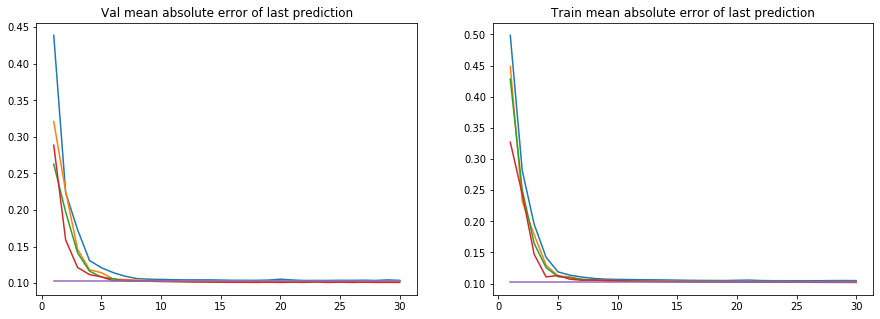

In [19]:
plot_train_curve_comparison(histories, [f'len{sl}' for sl in sequence_lengths], baseline_mae)

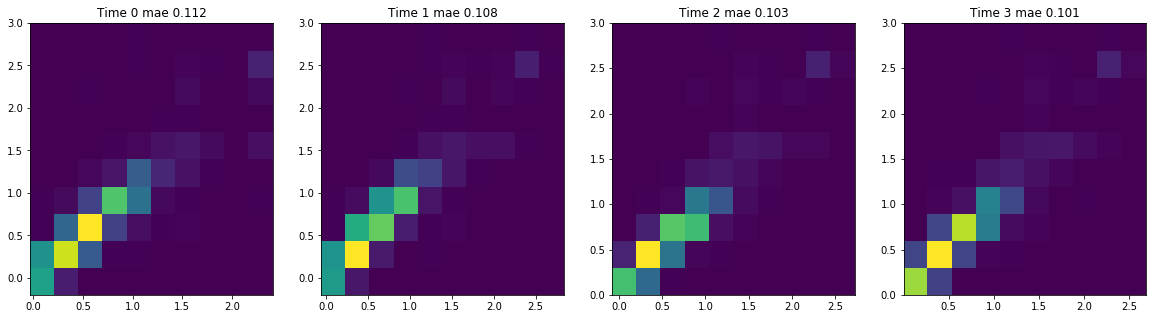

In [175]:
fig, axes = plt.subplots(1,4, figsize=(20,5))
for i in range(4):
    axes[i].hist2d(predictions[3][:,i,0], y_true[:,i,0])
    axes[i].set_title('Time {} mae {:.3f}'.format(i, mae_last_numpy(y_true, predictions[3], index=i)))

- with longer sequences gets a bit better, both in test and in val
- is better on val? retry for other split: not better anymore
    -> probably due to differences of train/val split
- at later times, predictions are a bit better (more precise)

### Input normalization

In [177]:
# train models with different sequence length
norms = [
    [None, None, None, None, None],
    [None, True, None, None, None],
    [None, True, True, None, None],
    [True, True, True, None, None]
]
names = ['nonorm', 'norm_dt', 'norm_dt_inj', 'norm_dt_inj_va']
histories = []
scores = []
predictions = []
for i, norm in enumerate(norms):
    config = {'model': {'norm': norm, 'sequence_length': 4}, 
              'training': {'tb_log_dir': 'logs/{}'.format(names[i])}}
    config = merged_config(default_config, config)
    est = Estimator(config)
    est.datasets_from_sequences(sequences=sequences_all)
    histories.append(est.train_model(verbose=1))
    scores.append(est.evaluate_model(est.val_dataset, verbose=0))
    predictions.append(est.predict_model(est.val_dataset))
    
    if i == 0:
        # calculate baseline 
        baseline_pred, y_true = est.val_dataset.get_value_list([IOVar.CUR_VA, IOVar.NEXT_VA], batch_size=512)
        baseline_mae = losses.mae_last_numpy(y_true, baseline_pred)

INFO:Estimator:Creating <class '__main__.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)


Epoch 1/30
18/18 [==============================] - 8s 436ms/step - loss: 0.3680 - mean_absolute_error: 0.3688 - mae_last: 0.3846 - val_loss: 0.3863 - val_mean_absolute_error: 0.3902 - val_mae_last: 0.3990
Epoch 2/30
18/18 [==============================] - 4s 241ms/step - loss: 0.3257 - mean_absolute_error: 0.3263 - mae_last: 0.3259 - val_loss: 0.3261 - val_mean_absolute_error: 0.3241 - val_mae_last: 0.3135
Epoch 3/30
18/18 [==============================] - 4s 242ms/step - loss: 0.2727 - mean_absolute_error: 0.2734 - mae_last: 0.2493 - val_loss: 0.2569 - val_mean_absolute_error: 0.2568 - val_mae_last: 0.2203
Epoch 4/30
18/18 [==============================] - 4s 243ms/step - loss: 0.2075 - mean_absolute_error: 0.2078 - mae_last: 0.1727 - val_loss: 0.1911 - val_mean_absolute_error: 0.1908 - val_mae_last: 0.1746
Epoch 5/30
18/18 [==============================] - 4s 247ms/step - loss: 0.1686 - mean_absolute_error: 0.1688 - mae_last: 0.1562 - val_loss: 0.1645 - val_mean_absolute_error: 

INFO:Estimator:Creating <class '__main__.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T


Epoch 1/30
18/18 [==============================] - 8s 467ms/step - loss: 0.3898 - mean_absolute_error: 0.3914 - mae_last: 0.3392 - val_loss: 0.3221 - val_mean_absolute_error: 0.3227 - val_mae_last: 0.2674
Epoch 2/30
18/18 [==============================] - 5s 264ms/step - loss: 0.2619 - mean_absolute_error: 0.2625 - mae_last: 0.2369 - val_loss: 0.2529 - val_mean_absolute_error: 0.2575 - val_mae_last: 0.1597
Epoch 3/30
18/18 [==============================] - 4s 250ms/step - loss: 0.2028 - mean_absolute_error: 0.2033 - mae_last: 0.1471 - val_loss: 0.1919 - val_mean_absolute_error: 0.1944 - val_mae_last: 0.1266
Epoch 4/30
18/18 [==============================] - 5s 259ms/step - loss: 0.1550 - mean_absolute_error: 0.1554 - mae_last: 0.1125 - val_loss: 0.1448 - val_mean_absolute_error: 0.1473 - val_mae_last: 0.1106
Epoch 5/30
18/18 [==============================] - 5s 260ms/step - loss: 0.1312 - mean_absolute_error: 0.1314 - mae_last: 0.1136 - val_loss: 0.1278 - val_mean_absolute_error: 

INFO:Estimator:Creating <class '__main__.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T
INFO:Estimator:Calculating normalization values for var IOVar.INJ_SHORT


Epoch 1/30
18/18 [==============================] - 8s 468ms/step - loss: 0.4046 - mean_absolute_error: 0.4065 - mae_last: 0.3616 - val_loss: 0.3173 - val_mean_absolute_error: 0.3192 - val_mae_last: 0.3109
Epoch 2/30
18/18 [==============================] - 5s 264ms/step - loss: 0.2544 - mean_absolute_error: 0.2550 - mae_last: 0.2408 - val_loss: 0.2481 - val_mean_absolute_error: 0.2518 - val_mae_last: 0.1643
Epoch 3/30
18/18 [==============================] - 5s 264ms/step - loss: 0.1929 - mean_absolute_error: 0.1934 - mae_last: 0.1483 - val_loss: 0.1818 - val_mean_absolute_error: 0.1836 - val_mae_last: 0.1244
Epoch 4/30
18/18 [==============================] - 5s 250ms/step - loss: 0.1478 - mean_absolute_error: 0.1481 - mae_last: 0.1134 - val_loss: 0.1442 - val_mean_absolute_error: 0.1457 - val_mae_last: 0.1198
Epoch 5/30
18/18 [==============================] - 5s 261ms/step - loss: 0.1294 - mean_absolute_error: 0.1295 - mae_last: 0.1136 - val_loss: 0.1296 - val_mean_absolute_error: 

INFO:Estimator:Creating <class '__main__.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)
INFO:Estimator:Calculating normalization values for var IOVar.CUR_VA
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T
INFO:Estimator:Calculating normalization values for var IOVar.INJ_SHORT


Epoch 1/30
18/18 [==============================] - 8s 463ms/step - loss: 0.4217 - mean_absolute_error: 0.4233 - mae_last: 0.3855 - val_loss: 0.3561 - val_mean_absolute_error: 0.3548 - val_mae_last: 0.2715
Epoch 2/30
18/18 [==============================] - 5s 265ms/step - loss: 0.2525 - mean_absolute_error: 0.2530 - mae_last: 0.2026 - val_loss: 0.2402 - val_mean_absolute_error: 0.2440 - val_mae_last: 0.1944
Epoch 3/30
18/18 [==============================] - 5s 264ms/step - loss: 0.1925 - mean_absolute_error: 0.1929 - mae_last: 0.1577 - val_loss: 0.1872 - val_mean_absolute_error: 0.1880 - val_mae_last: 0.1295
Epoch 4/30
18/18 [==============================] - 5s 264ms/step - loss: 0.1542 - mean_absolute_error: 0.1545 - mae_last: 0.1240 - val_loss: 0.1466 - val_mean_absolute_error: 0.1483 - val_mae_last: 0.1184
Epoch 5/30
18/18 [==============================] - 5s 266ms/step - loss: 0.1317 - mean_absolute_error: 0.1319 - mae_last: 0.1144 - val_loss: 0.1285 - val_mean_absolute_error: 

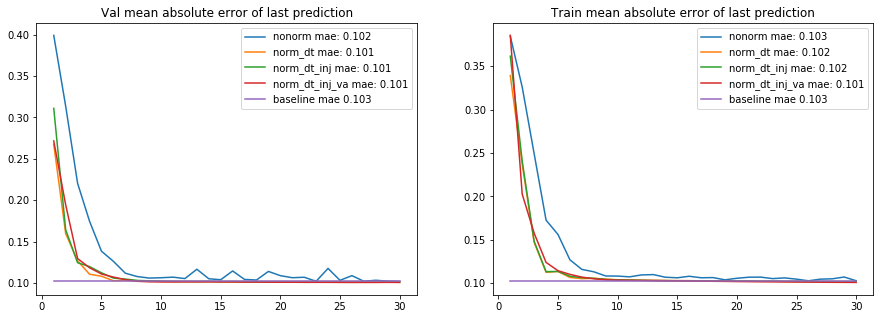

In [178]:
plot_train_curve_comparison(histories, names, baseline_mae)

- normalizing of delta_t is most important, others do not add much

### Input different injections directly

In [179]:
inputs = [
    [IOVar.CUR_VA,IOVar.DELTA_T,IOVar.INJ_LONG,IOVar.LENS_SURGERY],
    [IOVar.CUR_VA,IOVar.DELTA_T,IOVar.INJ_SHORT,IOVar.LENS_SURGERY],
]
names = ['inj_long', 'inj_short']
histories = []
scores = []
predictions = []
for i in range(2):
    config = {'model': {'norm': [None, True, None, None, None], 'sequence_length': 4, 'input_vars':inputs[i]}, 
              'training': {'tb_log_dir': 'logs/{}'.format(names[i])}}
    config = merged_config(default_config, config)
    est = Estimator(config)
    est.datasets_from_sequences(sequences=sequences_all)
    histories.append(est.train_model(verbose=1))
    scores.append(est.evaluate_model(est.val_dataset, verbose=0))
    predictions.append(est.predict_model(est.val_dataset))
    
    if i == 0:
        # calculate baseline 
        baseline_pred, y_true = est.val_dataset.get_value_list([IOVar.CUR_VA, IOVar.NEXT_VA], batch_size=512)
        baseline_mae = mae_last_numpy(y_true, baseline_pred)

INFO:Estimator:Creating <class '__main__.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_LONG: 6>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T


Epoch 1/30
18/18 [==============================] - 8s 467ms/step - loss: 0.4607 - mean_absolute_error: 0.4625 - mae_last: 0.4234 - val_loss: 0.3935 - val_mean_absolute_error: 0.3949 - val_mae_last: 0.3135
Epoch 2/30
18/18 [==============================] - 5s 257ms/step - loss: 0.3111 - mean_absolute_error: 0.3118 - mae_last: 0.2861 - val_loss: 0.2913 - val_mean_absolute_error: 0.2939 - val_mae_last: 0.2127
Epoch 3/30
18/18 [==============================] - 5s 258ms/step - loss: 0.2461 - mean_absolute_error: 0.2466 - mae_last: 0.1893 - val_loss: 0.2284 - val_mean_absolute_error: 0.2330 - val_mae_last: 0.1612
Epoch 4/30
18/18 [==============================] - 5s 254ms/step - loss: 0.1905 - mean_absolute_error: 0.1910 - mae_last: 0.1373 - val_loss: 0.1728 - val_mean_absolute_error: 0.1765 - val_mae_last: 0.1244
Epoch 5/30
18/18 [==============================] - 5s 254ms/step - loss: 0.1472 - mean_absolute_error: 0.1475 - mae_last: 0.1156 - val_loss: 0.1399 - val_mean_absolute_error: 

INFO:Estimator:Creating <class '__main__.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9091 train (79.0%), 1142 val (9.9%), 1277 test (11.1%)
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T


Epoch 1/30
18/18 [==============================] - 8s 457ms/step - loss: 0.4403 - mean_absolute_error: 0.4421 - mae_last: 0.3974 - val_loss: 0.3700 - val_mean_absolute_error: 0.3715 - val_mae_last: 0.3085
Epoch 2/30
18/18 [==============================] - 5s 261ms/step - loss: 0.2873 - mean_absolute_error: 0.2882 - mae_last: 0.2572 - val_loss: 0.2598 - val_mean_absolute_error: 0.2630 - val_mae_last: 0.1577
Epoch 3/30
18/18 [==============================] - 5s 262ms/step - loss: 0.2088 - mean_absolute_error: 0.2093 - mae_last: 0.1431 - val_loss: 0.1972 - val_mean_absolute_error: 0.2013 - val_mae_last: 0.1465
Epoch 4/30
18/18 [==============================] - 5s 264ms/step - loss: 0.1629 - mean_absolute_error: 0.1632 - mae_last: 0.1220 - val_loss: 0.1522 - val_mean_absolute_error: 0.1545 - val_mae_last: 0.1123
Epoch 5/30
18/18 [==============================] - 5s 260ms/step - loss: 0.1357 - mean_absolute_error: 0.1359 - mae_last: 0.1115 - val_loss: 0.1318 - val_mean_absolute_error: 

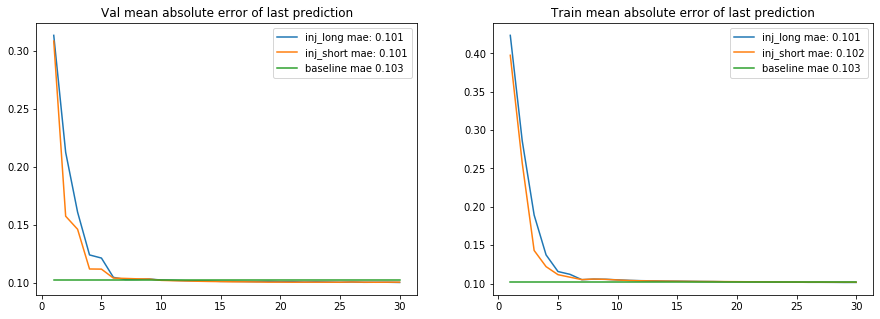

In [181]:
plot_train_curve_comparison(histories, names, baseline_mae)

- in this case, inputing injections as summed number has same performance as inputting list of injections

### Different LSTM cells

# OLD LSTM MODEL FUNCTION

In [ ]:
def lstm_model(sequence_length, num_inputs=4, log_name=None):
    # input has 3 measurements, with 4 values each (curva, deltat, injections, lenssur)
    input_x = tf.tensorflow.keras.layers.Input((sequence_length, num_inputs), dtype='float32')

    # process input by neural network to calculate embedding
    xs = [input_x[:,i] for i in range(sequence_length)]
    embedding_layer = tf.tensorflow.keras.layers.Dense(32, activation='relu')
    #norm_layer = tf.tensorflow.keras.layers.LayerNormalization(axis=-1 , center=True , scale=True)
    xs = [embedding_layer(x) for x in xs]
    reshape_layer = tf.tensorflow.keras.layers.Reshape((1,32))
    xs = [reshape_layer(x) for x in xs]
    embedded_x = tf.concat(xs, axis=1)

    # LSTM layer
    lstm_layer = tf.tensorflow.keras.layers.LSTM(units=64, return_sequences=True)
    #norm2_layer = tf.tensorflow.keras.layers.LayerNormalization(axis=-1 , center=True , scale=True)
    lstm_x = lstm_layer(embedded_x)

    # logMAR prediction layer
    xs = [lstm_x[:,i] for i in range(sequence_length)]
    output_layer = tf.tensorflow.keras.layers.Dense(1, activation=None)
    prediction = tf.concat([output_layer(x) for x in xs], axis=1)

    model = tf.tensorflow.keras.Model(input_x, prediction, name='logMAR_LSTM_{}'.format(sequence_length))
    
    def mae_last(y_true, y_pred):
        return tf.math.abs(y_pred[:,-1] - y_true[:,-1])
        
    # set up tb logging
    callbacks = []
    if log_name is not None:
        logdir = "logs/{}/{}".format(log_name, datetime.now().strftime("%Y%m%d-%H%M%S"))
        file_writer = tf.summary.create_file_writer(logdir + "/metrics")
        file_writer.set_as_default()
        log_weights_callback = tf.tensorflow.keras.callbacks.LambdaCallback(on_epoch_end=partial(log_variable_summaries, layers=[embedding_layer, lstm_layer, output_layer]))
        tb_callback = tf.tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)
        callbacks = [tb_callback, log_weights_callback]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.mean_absolute_error,
        metrics=[tf.losses.mean_absolute_error, mae_last]
    )
    return model, callbacks

